# Crashspot – Week 8 Starter

**Focus:** Model interpretation + spatial integration

SHAP not available; using permutation importance instead. To enable: pip install shap
Model loaded: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


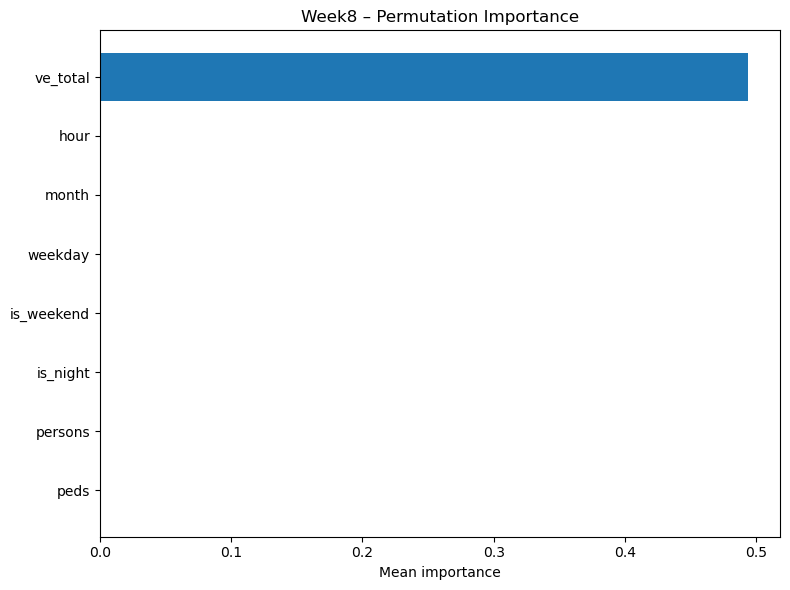

Saved map: ../docs/maps/week8_predicted_hotspots.html
Week 8 completed cells ready.


In [1]:

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
import joblib

# Optional: SHAP, Folium
try:
    import shap
    HAS_SHAP = True
except Exception as e:
    HAS_SHAP = False
    print("SHAP not available; using permutation importance instead. To enable: pip install shap")

try:
    import folium
    HAS_FOLIUM = True
except Exception as e:
    HAS_FOLIUM = False
    print("Folium not available; skipping map export. To enable: pip install folium")

FIG_DIR = "../output/figures"
MAP_DIR = "../docs/maps"
DATA_FEATURES = "../data_clean/week5_features.csv"  # or week6_features.csv if you created it
GEO_PATH = "../data_clean/fars_monroe_2022_2023_clean.geojson"  # adjust if different
MODEL_PATH = "../models/week7_best_model.pkl"  # Use the tuned model from Week 7

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MAP_DIR, exist_ok=True)

# Load data + model
df = pd.read_csv(DATA_FEATURES)
X = df.drop(columns=["target_multiveh"])
y = df["target_multiveh"]
model = joblib.load(MODEL_PATH)
print("Model loaded:", type(model))

# --- Interpretation ---
# 1) Permutation importance (model-agnostic)
perm = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean}).sort_values("importance", ascending=False)
imp_df.head(20)

plt.figure(figsize=(8,6))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.title("Week8 – Permutation Importance")
plt.xlabel("Mean importance")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "week8_permutation_importance.png"), dpi=150)
plt.show()

# 2) Optional SHAP (tree/linear supported). This might be slow depending on model.
if HAS_SHAP:
    try:
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, "week8_shap_beeswarm.png"), dpi=150, bbox_inches="tight")
        plt.show()
    except Exception as e:
        print("SHAP explanation failed:", e)

# --- Spatial integration (optional) ---
# Expected: your GeoJSON contains either same rows or a join key 'case_id' that is present in DATA_FEATURES
try:
    import geopandas as gpd
    gdf = gpd.read_file(GEO_PATH)
    # Heuristic: if an id exists, merge on it; else if same length, align by index
    join_key = None
    for k in ["case_id", "ST_CASE", "id", "record_id"]:
        if k in gdf.columns and k in df.columns:
            join_key = k
            break

    if join_key:
        merged = gdf.merge(df.assign(pred=model.predict_proba(X)[:,1]), on=join_key, how="inner")
    else:
        if len(gdf) == len(df):
            merged = gdf.copy()
            merged["pred"] = model.predict_proba(X)[:,1]
        else:
            merged = None
            print("Cannot align GeoJSON to features automatically. Add a common key like 'case_id'.")

    if merged is not None and HAS_FOLIUM:
        center = [merged.geometry.y.mean(), merged.geometry.x.mean()]
        m = folium.Map(location=center, zoom_start=11)
        # Simple circle markers sized by predicted risk
        for _, r in merged.iterrows():
            try:
                lat, lon = r.geometry.y, r.geometry.x
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=3 + 7*float(r["pred"]),
                    popup=f"pred={r['pred']:.2f}",
                    fill=True
                ).add_to(m)
            except Exception:
                continue
        out_map = os.path.join(MAP_DIR, "week8_predicted_hotspots.html")
        m.save(out_map)
        print("Saved map:", out_map)
    elif merged is not None:
        print("Folium not installed; skipping web map export.")
except Exception as e:
    print("Spatial integration skipped due to:", e)

print("Week 8 completed cells ready.")
